In [1]:
import pandas as pd
from skimage import io
from skimage import transform
from skimage import filters
from Preprocess.filter import get_high_var_genes
from Preprocess.image import cut_image
from IO.IOUtil import merge_bin_coordinate
from anndata import AnnData
from Algorithm.distance import build_gmm_distance_array
from Algorithm.distribution import *
from Utils.plot import *
import scanpy as sc
import numpy as np
import seaborn as sns

In [2]:
ms_position_df = pd.read_csv("E:/data/RegionC/RegionC_allpeak5ppm_immunoloc.csv",
                             sep=',',
                             index_col=0)
ms_position_df.columns = ms_position_df.columns.str.replace('pxl_row_in_immuno', 'x')
ms_position_df.columns = ms_position_df.columns.str.replace('pxl_col_in_immuno', 'y')
ms_df = pd.read_csv("E:/data/RegionC/Abate11_RegionC_pixmz5ppmfilter.csv", sep=',', index_col=0)
ms_position_df.index = ms_position_df.index.str.lstrip('x')
ms_adata = AnnData(X=ms_df.T)
ms_adata.obs = ms_position_df.reindex(ms_adata.obs.index)

In [3]:
# [index_col = 0] -> [Set the first column as row name]
raw_df = pd.read_csv("E:/data/brain10x.csv",
                     sep=',',
                     index_col=0)
APP23_1 = raw_df.filter(regex=r'^APP23_I_')
APP23_1 = APP23_1.rename(columns=lambda x: x.replace('APP23_I_', ''))
adata = AnnData(X=APP23_1.T)
position_df = pd.read_csv('E:/data/RegionC/RegionC_10x_immunoloc.csv', sep=',', index_col=0)
# replace '-' to '.', example: 'AAACAAGTATCTCCCA-1' to 'AAACAAGTATCTCCCA.1'
position_df.index = position_df.index.str.replace('-', '.')
position_df.columns = position_df.columns.str.replace('pxl_row_in_immuno', 'x')
position_df.columns = position_df.columns.str.replace('pxl_col_in_immuno', 'y')
adata.obs = position_df.reindex(adata.obs.index)

In [6]:
obs_to_remove = ms_adata[(ms_adata.obs['x'] < adata.obs['x'].min()) |
                         (ms_adata.obs['x'] > adata.obs['x'].max()) |
                         (ms_adata.obs['y'] > adata.obs['y'].max()) |
                         (ms_adata.obs['y'] < adata.obs['y'].min())].obs_names
ms_adata = ms_adata[~ms_adata.obs_names.isin(obs_to_remove), :]

In [4]:
ms_adata.obs['x'] = merge_bin_coordinate(ms_adata.obs['x'], ms_adata.obs['x'].min(), bin_size=80)
ms_adata.obs['y'] = merge_bin_coordinate(ms_adata.obs['y'], ms_adata.obs['y'].min(), bin_size=80)

In [5]:
adata.obs['x'] = merge_bin_coordinate(adata.obs['x'], adata.obs['x'].min(), bin_size=80)
adata.obs['y'] = merge_bin_coordinate(adata.obs['y'], adata.obs['y'].min(), bin_size=80)

In [7]:
sc.pp.filter_genes(adata, min_cells=200)
adata

AnnData object with n_obs × n_vars = 2000 × 11769
    obs: 'in_tissue', 'array_row', 'array_col', 'x', 'y'
    var: 'n_cells'

In [8]:
obs_list = []
r = 2
for i in ms_adata:
    x = int(i.obs['x'])
    y = int(i.obs['y'])
    obs = adata.obs[(x - r < adata.obs['x']) & (adata.obs['x'] < x + r) & (adata.obs['y'] < y + r) & (adata.obs['y'] > y - r)]
    if len(obs)>0:
        obs_list.append(i.obs.index[0])
ms_adata = ms_adata[ms_adata.obs_names.isin(obs_list), :]
ms_adata

View of AnnData object with n_obs × n_vars = 1718 × 2916
    obs: 'y', 'x'

In [ ]:
# Clean up data
sc.pp.calculate_qc_metrics(ms_adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(ms_adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(ms_adata.obs["total_counts"][ms_adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(ms_adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(ms_adata.obs["n_genes_by_counts"][ms_adata.obs["n_genes_by_counts"] < 2000], kde=False, bins=60, ax=axs[3])

In [9]:
sc.pp.normalize_total(ms_adata, inplace=True,
                      target_sum=1e4,
                      exclude_highly_expressed=True)
sc.pp.log1p(ms_adata)

In [10]:
sc.pp.highly_variable_genes(ms_adata, n_top_genes=2500)
new_ms_list = list(ms_adata.var[ms_adata.var['highly_variable']].index)

In [11]:
import scanpy as sc
sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor='seurat_v3')

In [13]:
adata.X.max()

15027

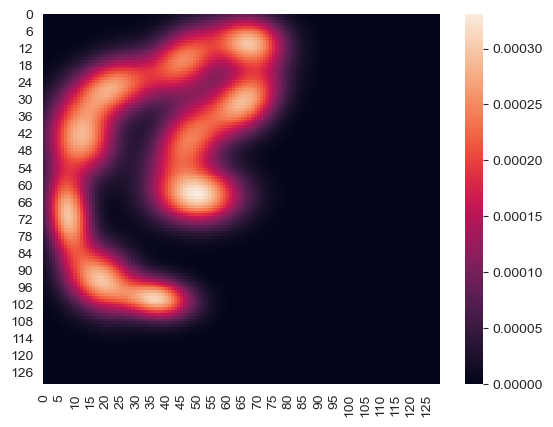

In [6]:
from Algorithm.distance import get_exp_array
def array_to_list(matrix) -> np.array:
    coords = np.column_stack(np.where(matrix > 0))
    counts = matrix[matrix > 0].flatten()
    result = np.repeat(coords, counts, axis=0)
    return result
def get_gmm(matrix, n_comp=10):
    arr = np.array(matrix, dtype=np.int32)
    result = array_to_list(arr)
    gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=200).fit(result)
    return gmm

image = io.imread("E:/data/RegionC/RegionCplaqueHires.png")
cropped_image = cut_image(image)
resized = transform.resize(cropped_image, get_exp_array(adata, adata.var.index[0]).shape)
gaussian = filters.gaussian(resized, 3)
binary = np.where(gaussian > np.percentile(gaussian, 40), 1, 0)
gmm = get_gmm(binary, n_comp=10)

start = 0
end = 130
num = end - start
x = np.linspace(start, end, num)
y = np.linspace(start, end, num)
x_range, y_range = np.meshgrid(x, y)
x_y = np.column_stack([x_range.flat, y_range.flat])
# calculate the density
density = gmm.score_samples(x_y)
density = density.reshape(x_range.shape)
sns.heatmap(np.exp(density))
plt.show()

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [14]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata,
                      inplace=True)
sc.pp.log1p(adata)
# # # Select top variable genes
# sc.pp.highly_variable_genes(adata, n_top_genes=300)
# new_list = list(adata.var[adata.var['highly_variable']].index)

In [15]:
var_list = list(adata.var[adata.var['highly_variable']].index)

In [18]:
len(var_list)

5000

In [129]:
from skimage import morphology
from tqdm import tqdm

def filter_genes(adata):
    gene_list = list(adata.var.index)
    new_list = []
    for i in tqdm(gene_list, desc='Processing...'):
        matrix = get_exp_array(adata, i)
        eroded_image = morphology.erosion(matrix, np.ones((5, 5), dtype=np.bool_))
        if eroded_image.max() > 0:
            new_list.append(i)
    return new_list
li = filter_genes(adata=adata)

Processing...: 100%|██████████| 11769/11769 [00:53<00:00, 220.94it/s]


['Mrpl15',
 'Tcea1',
 'Atp6v1h',
 'Rb1cc1',
 'Pcmtd1',
 '3110035E14Rik',
 'Vcpip1',
 'Cops5',
 'Arfgef1',
 'Ncoa2',
 'Tram1',
 'Rpl7',
 'Stau2',
 'Ube2w',
 'Eloc',
 'Tmem70',
 'Gdap1',
 'Paqr8',
 'Tmem14a',
 'Rims1',
 'Ogfrl1',
 'Smap1',
 'Sdhaf4',
 'Lmbrd1',
 'Adgrb3',
 'Phf3',
 'Ptp4a1',
 'Zfp451',
 'Bend6',
 'Dst',
 'Arhgef4',
 'Fam168b',
 'Plekhb2',
 'Uggt1',
 'Kansl3',
 'Lman2l',
 'Cnnm3',
 'Cox5b',
 'Actr1b',
 'Tmem131',
 'Inpp4a',
 'Coa5',
 'Unc50',
 '2010300C02Rik',
 'Mrpl30',
 'Txndc9',
 'Eif5b',
 'Lonrf2',
 'Chst10',
 'Rpl31',
 'Rnf149',
 'Creg2',
 'Map4k4',
 'Pantr1',
 'Mrps9',
 'Uxs1',
 'Tpp2',
 'Slc39a10',
 'Tmeff2',
 'Gls',
 'Mfsd6',
 'Hecw2',
 'Pgap1',
 'Sf3b1',
 'Hspd1',
 'Hspe1',
 'Mob4',
 'Plcl1',
 'Bzw1',
 'Clk1',
 'Fam126b',
 'Ndufb3',
 'Trak2',
 'Sumo1',
 'Nop58',
 'Bmpr2',
 'Fam117b',
 'Wdr12',
 'Abi2',
 'Raph1',
 'Ndufs1',
 'Eef1b2',
 'Zdbf2',
 'Adam23',
 'Klf7',
 'Creb1',
 'Idh1',
 'Pikfyve',
 'Map2',
 'Unc80',
 'Lancl1',
 'Erbb4',
 'Rpl37a',
 'Igfbp2',
 'Igfbp5

In [19]:
from Algorithm.distribution import fit_gmms

warnings.filterwarnings("ignore")

gmm_dict = fit_gmms(adata, var_list, n_comp=10, max_iter=100)
ms_gmm_dict = fit_gmms(ms_adata, gene_name_list=new_ms_list, n_comp=10, max_iter=100)

Fitting GMM...: 100%|██████████| 2500/2500 [05:01<00:00,  8.29it/s]


In [34]:
from Algorithm.distance import distribution_distance


def get_gmm_distance_array(gmm, gmm_dict):
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_dict = {}
    for gene in range(gene_counts):
        distance = distribution_distance(gmm, gmm_dict[gene_list[gene]])
        distance_dict[gene_list[gene]] = distance
    df = pd.DataFrame.from_dict(distance_dict, orient='index')
    sorted_df = df.sort_values(0)
    return sorted_df

result_dict = {}
for i in tqdm(list(ms_gmm_dict.keys()),desc='process'):
    df = get_gmm_distance_array(ms_gmm_dict[i], gmm_dict)
    result_dict[i] = list(df[:10].index)


process: 100%|██████████| 2500/2500 [2:01:51<00:00,  2.92s/it]  


In [35]:
r = pd.DataFrame.from_dict(result_dict,orient='index')


In [36]:
r.to_csv('result.csv', sep=',')

In [23]:
list(ms_gmm_dict.keys())[:10]

['152.021260634517',
 '152.022352816309',
 '154.255994635828',
 '154.257294344291',
 '154.258457137165',
 '154.259305828387',
 '154.709439761684',
 '156.514285348876',
 '156.515429678719',
 '156.51602414253']

In [228]:
from Algorithm.distance import compare_gmm_distance

df = compare_gmm_distance(gmm, gmm_dict)

Building distance array...: 100%|██████████| 300/300 [00:00<00:00, 949.38it/s]


In [ ]:
arr = build_gmm_distance_array(gmm_dict)

In [11]:
from Algorithm.distance import distribution_distance


def get_gmm_distance_array(gmm, gmm_dict):
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_dict = {}
    for gene in tqdm(range(gene_counts), desc='Building distance array...'):
        distance = distribution_distance(gmm, gmm_dict[gene_list[gene]])
        distance_dict[gene_list[gene]] = distance
    df = pd.DataFrame.from_dict(distance_dict, orient='index')
    sorted_df = df.sort_values(0)
    return sorted_df


df = get_gmm_distance_array(gmm, gmm_dict)

Building distance array...: 100%|██████████| 11769/11769 [00:12<00:00, 908.92it/s] 


In [13]:
list(df[:30].index)

['Slc30a3',
 'Slc8a2',
 'Adcy9',
 'Zbtb18',
 'Fbxw7',
 'Ptk2b',
 'Synpo',
 'Cacnb3',
 'Arl15',
 'Mtmr12',
 'Phyhip',
 'A030001D20Rik',
 'Itpka',
 'Rasgrp1',
 'Zdhhc23',
 'Mfsd13a',
 'Cnnm1',
 'Tmem198',
 'Adcy1',
 '2700081O15Rik',
 'Chrm1',
 'Large1',
 'Prmt8',
 'Sowaha',
 'B4galnt1',
 'Rapgefl1',
 'Strn4',
 'Acbd6',
 'Gabrd',
 'Necab3']

In [23]:
df[df[0]<0.8]

,0
Slc30a3,0.575573
Slc8a2,0.593004
Adcy9,0.603308
Zbtb18,0.608678
Fbxw7,0.615467
...,...
Lin37,0.799303
Cul9,0.799499
Fam49b,0.799584
Scp2,0.799711


In [34]:
df.loc[var_list].sort_values(0)[:100]

,0
Adcy1,0.648522
Rrp1,0.677954
Hpca,0.699459
Tcf4,0.709254
Chn1,0.713571
...,...
Ppp3ca,0.862006
Ddb1,0.862299
Ddx5,0.863901
Rps26,0.863903


In [ ]:
result,_ = cluster(arr, mds_components=50, n_clusters=10)

In [ ]:
from Utils.plot import plot_heatmap

plot_heatmap(result,
             label=0,
             adata=adata,
             vmax=90,
             num_cols=4,
             cmap='viridis')

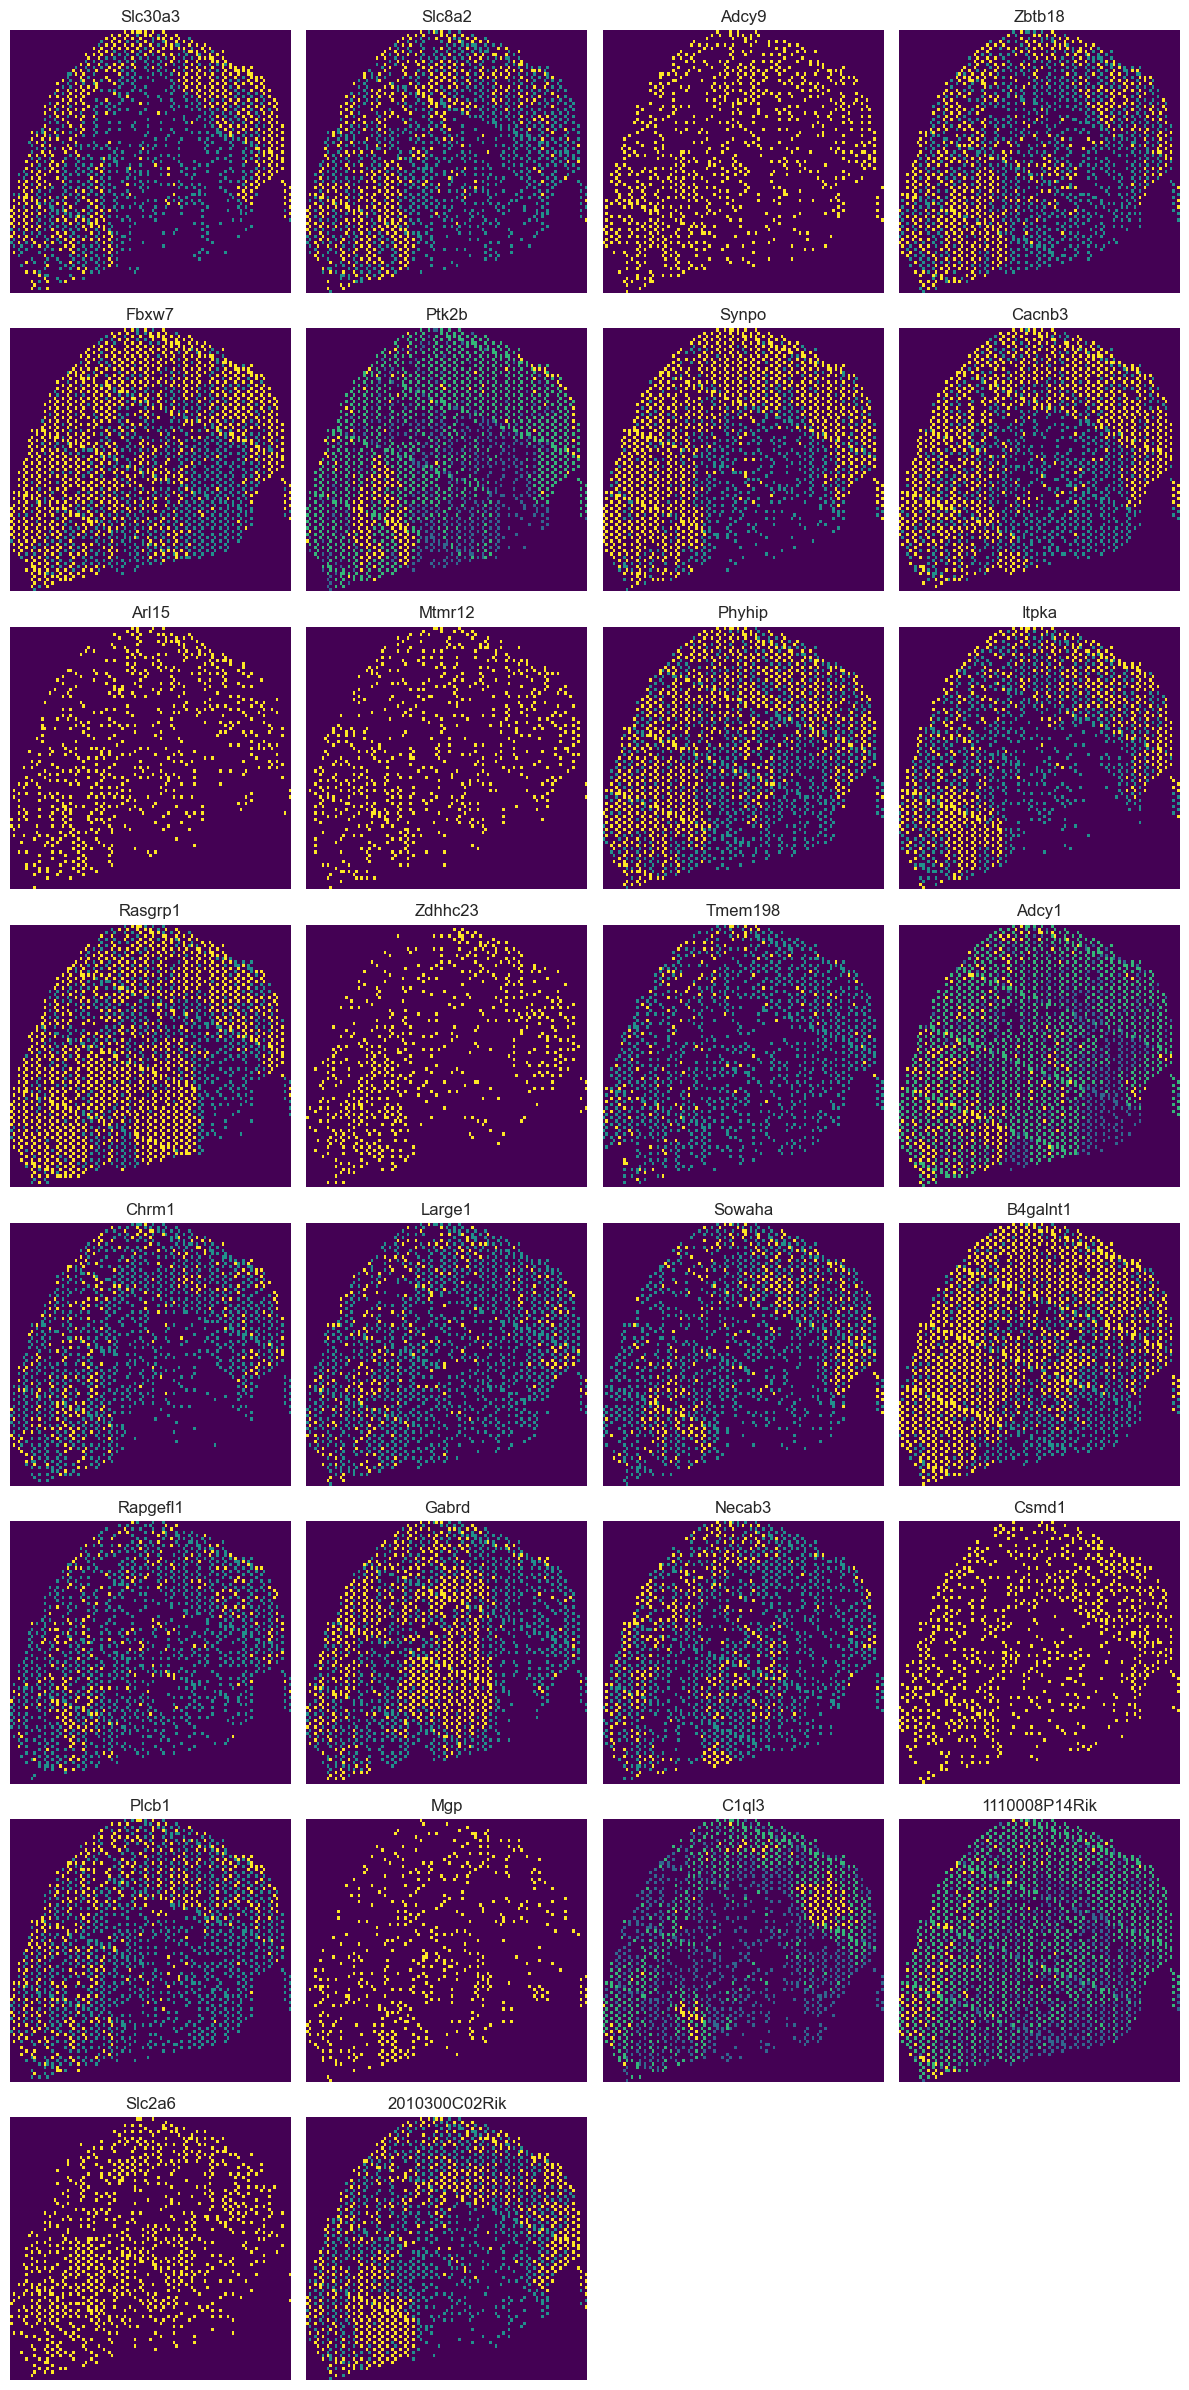

In [44]:
from Utils.plot import plot_heatmap
plot_heatmap(gene_list=list(df.loc[var_list].sort_values(0)[:30].index), adata=adata, vmax=99, num_cols=4)

In [49]:
df.loc[var_list].sort_values(0)[:300].to_csv('gene_related_to_pic_top300.csv', index=True)

In [ ]:
plot_heatmap(result,2, adata=adata, n_gene=20, vmax=99)

In [ ]:
plot_pattern(result, adata, vmax=99)

In [246]:
result[result['gene_id'] == 'hAPP']

,gene_id,labels
19,hAPP,2


In [247]:
adata.var.loc['hAPP']

n_cells                 1998
highly_variable        False
means               4.013074
dispersions          3.38645
dispersions_norm     0.15275
Name: hAPP, dtype: object

<Axes: >

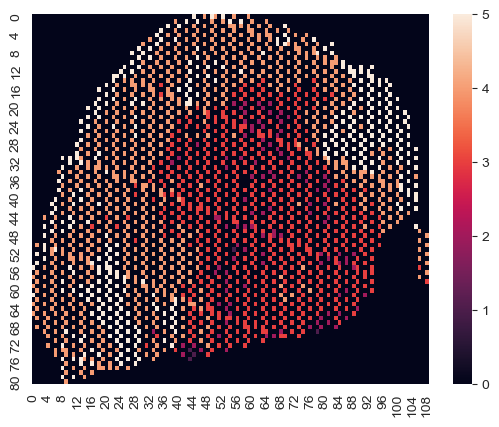

In [248]:
sns.heatmap(get_exp_array(adata, 'hAPP'))

<Axes: >

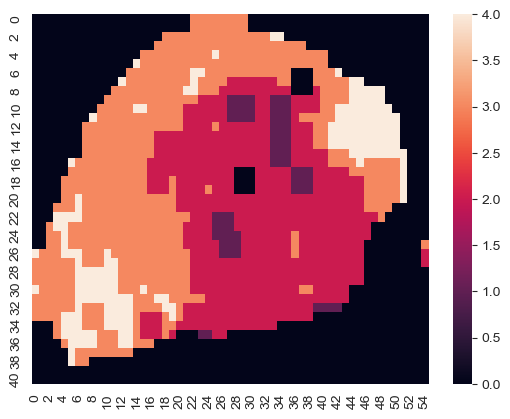

In [163]:
eroded_image = morphology.erosion(get_exp_array(adata, 'hAPP'), np.ones((3, 3), dtype=np.bool_))
sns.heatmap(eroded_image)

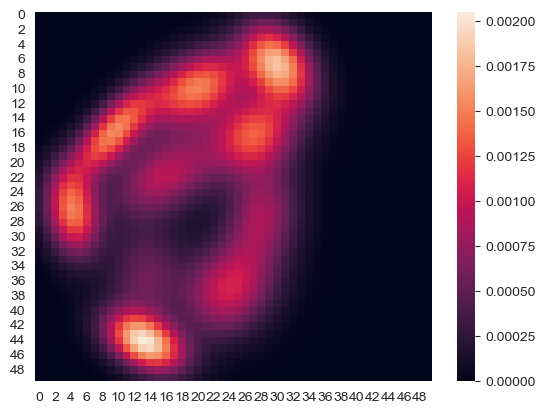

In [160]:
view_gmm(get_gmm(eroded_image, n_comp=10),(0,50))

In [162]:
distribution_distance(gmm, get_gmm(eroded_image, n_comp=10))

1.750538540600776

In [111]:
from scipy.signal import convolve2d
from Utils.utils import *
con = convolve2d(get_exp_array(adata, 'Pld3'),get_laplacian_kernel())

<Axes: >

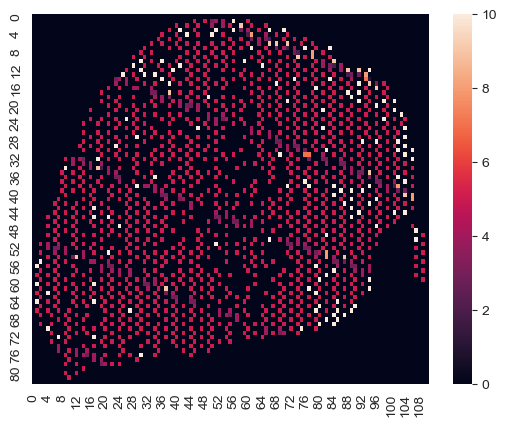

In [112]:
con[con<0]=0
sns.heatmap(con)

In [237]:
result = result.sort_values('labels')
result.to_csv('gene_seurat_result.csv', index=False)